In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/DATA/weatherAUS.csv')

print("Dataset shape:", data.shape)
print(data.head())


Dataset shape: (145460, 23)
         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  Rai

In [4]:
print("\nBasic Info:")
print(data.info())
print("\nMissing values count:\n", data.isnull().sum())
print("\nClass distribution:\n", data['RainTomorrow'].value_counts())



Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       8

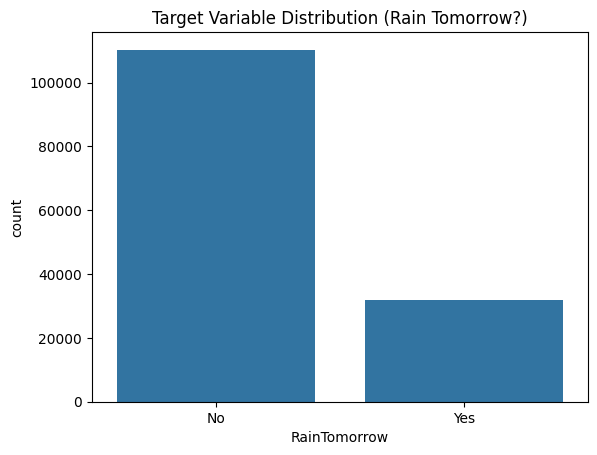

In [5]:
sns.countplot(x='RainTomorrow', data=data)
plt.title("Target Variable Distribution (Rain Tomorrow?)")
plt.show()

In [6]:
data.dropna(subset=['RainTomorrow'], inplace=True)

features = data.drop(columns=['RainTomorrow', 'Date'])
target = data['RainTomorrow']

In [7]:
le = LabelEncoder()
target = le.fit_transform(target)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify=target
)

print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (106644, 21)
Test set size: (35549, 21)


In [9]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
        X_test[col] = X_test[col].fillna(X_test[col].mode()[0])
        lbl = LabelEncoder()
        X_train[col] = lbl.fit_transform(X_train[col])
        X_test[col] = lbl.transform(X_test[col])
    else:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_test[col].median())

In [10]:
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [11]:
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=np.number).columns

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

display(X_train.head())

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
10523,-0.894422,0.645468,0.150899,1.588260,0.439181,0.164619,0.416465,0.235816,1.773585,0.486433,...,0.613984,1.169688,-0.072412,1.148688,1.384041,1.025875,0.141100,-0.012323,0.352725,1.878662
60652,-1.245241,1.521606,2.679981,-0.274846,-0.122843,0.164619,1.055037,3.052499,-1.549020,1.366231,...,0.843382,-1.679752,-2.019285,-1.045126,-1.354694,-1.590002,0.141100,1.854462,2.852383,-0.532294
118155,0.579019,-0.653093,-0.368968,-0.274846,-0.747314,-1.496040,1.055037,-0.068691,-1.327513,-1.493114,...,-0.418308,-0.677171,-0.607802,1.237627,1.099692,1.025875,1.557106,-0.938001,-0.373919,-0.532294
43709,1.631477,0.598532,-0.397069,0.692082,-0.122843,0.164619,-0.009249,1.758347,0.887557,0.926332,...,0.155188,0.008805,1.971805,0.125897,0.351403,-1.590002,1.557106,0.064817,-0.882571,1.878662
36536,1.280657,0.363853,1.007977,-0.274846,3.686430,1.753076,1.055037,1.073208,1.773585,1.586181,...,1.072780,-1.626985,-2.116628,-0.852426,-0.651303,-1.590002,-2.218910,0.296237,0.992173,-0.532294


In [12]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [13]:
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

In [14]:
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Accuracy Score: 0.8447776308756927


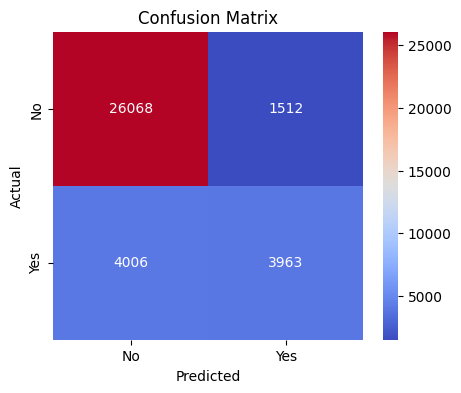

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [16]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.95      0.90     27580
           1       0.72      0.50      0.59      7969

    accuracy                           0.84     35549
   macro avg       0.80      0.72      0.75     35549
weighted avg       0.83      0.84      0.83     35549



In [17]:
new_threshold = 0.4
y_pred_new = (y_pred_prob >= new_threshold).astype(int)
print(f"\nAccuracy with threshold {new_threshold}:", accuracy_score(y_test, y_pred_new))


Accuracy with threshold 0.4: 0.8391234633885623


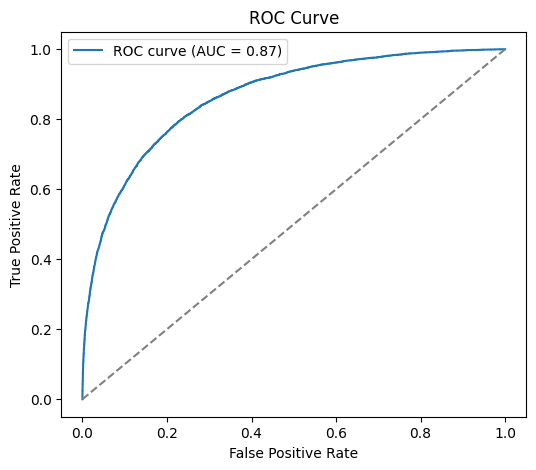

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [19]:
scaler = StandardScaler()

# Identify numerical columns (excluding the encoded categorical columns which are now numerical)
numerical_cols = X_train.select_dtypes(include=np.number).columns

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

display(X_train.head())

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
10523,-0.894422,0.645468,0.150899,1.588260,0.439181,0.164619,0.416465,0.235816,1.773585,0.486433,...,0.613984,1.169688,-0.072412,1.148688,1.384041,1.025875,0.141100,-0.012323,0.352725,1.878662
60652,-1.245241,1.521606,2.679981,-0.274846,-0.122843,0.164619,1.055037,3.052499,-1.549020,1.366231,...,0.843382,-1.679752,-2.019285,-1.045126,-1.354694,-1.590002,0.141100,1.854462,2.852383,-0.532294
118155,0.579019,-0.653093,-0.368968,-0.274846,-0.747314,-1.496040,1.055037,-0.068691,-1.327513,-1.493114,...,-0.418308,-0.677171,-0.607802,1.237627,1.099692,1.025875,1.557106,-0.938001,-0.373919,-0.532294
43709,1.631477,0.598532,-0.397069,0.692082,-0.122843,0.164619,-0.009249,1.758347,0.887557,0.926332,...,0.155188,0.008805,1.971805,0.125897,0.351403,-1.590002,1.557106,0.064817,-0.882571,1.878662
36536,1.280657,0.363853,1.007977,-0.274846,3.686430,1.753076,1.055037,1.073208,1.773585,1.586181,...,1.072780,-1.626985,-2.116628,-0.852426,-0.651303,-1.590002,-2.218910,0.296237,0.992173,-0.532294


In [20]:
selector = RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)
selector = selector.fit(X_train, y_train)
print("\nTop 10 Features Selected by RFE:")
print(X_train.columns[selector.support_])


Top 10 Features Selected by RFE:
Index(['MaxTemp', 'Sunshine', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud3pm', 'Temp3pm', 'RainToday'],
      dtype='object')


In [21]:
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Cross-Validation Scores: [0.83988935 0.84059262 0.84228046 0.84570303 0.83880345]
Mean CV Accuracy: 0.8414537840822435


In [22]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid_search = GridSearchCV(LogisticRegression(max_iter=200), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Parameters from GridSearch:", grid_search.best_params_)
print("Best CV Score from GridSearch:", grid_search.best_score_)


Best Parameters from GridSearch: {'C': 0.1, 'solver': 'lbfgs'}
Best CV Score from GridSearch: 0.8415475522497765


In [23]:
final_acc = accuracy_score(y_test, grid_search.predict(X_test))
print("\nFinal Model Accuracy after tuning:", final_acc)
print("Conclusion: Logistic Regression performs reasonably well on this dataset for predicting if it will rain tomorrow.")


Final Model Accuracy after tuning: 0.8446651101296802
Conclusion: Logistic Regression performs reasonably well on this dataset for predicting if it will rain tomorrow.
